In [1]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy.signal import find_peaks as fp
from sklearn import preprocessing
from lmfit.models import LorentzianModel, QuadraticModel, LinearModel

In [23]:
'''
RAW DATA EXCTRACTION.
'''
# Path Search and Data Extraction
path = 'C1_azul.txt'
filename = path[:-4]
df_raw = pd.read_csv(path, sep='\t', names=['shift','intensity'], index_col = 'shift')

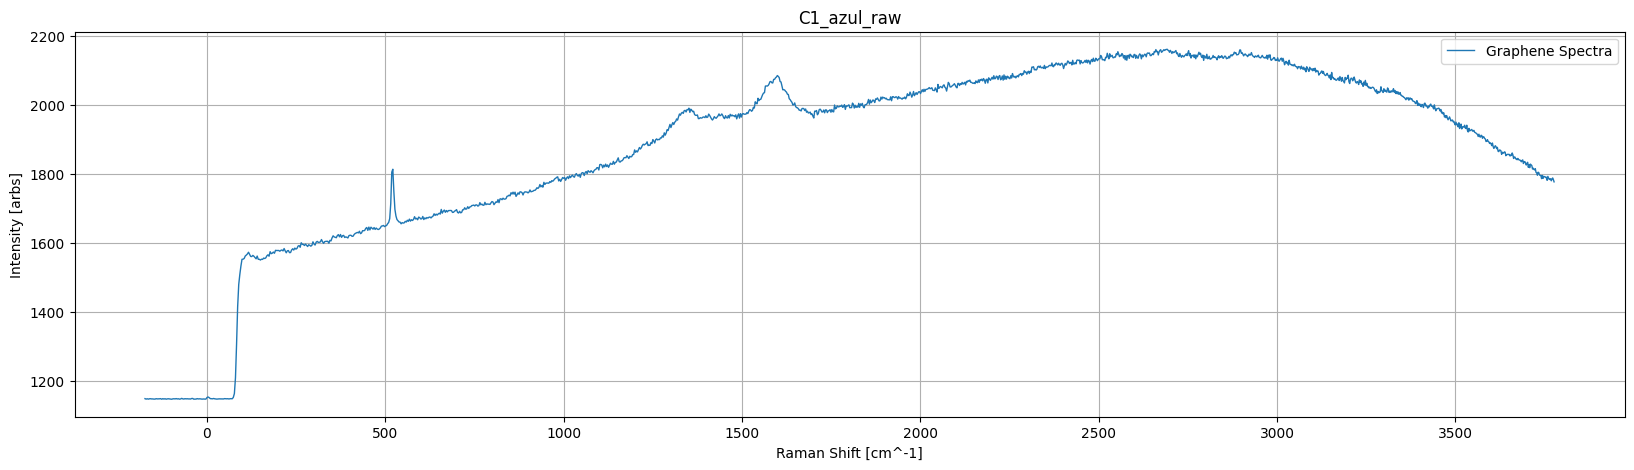

,intensity
shift,
-173.428722,1148.283325
-170.294344,1146.983276
-167.160990,1147.949951
-164.028661,1146.916626
-160.897355,1147.883301
...,...
3768.705892,1780.199951
3770.648649,1785.666626
3772.590889,1788.383301


In [24]:
# Graphing
fig0 = plt.figure(figsize=(20,5))
ax = fig0.add_subplot(1,1,1)
ax.plot(df_raw,linewidth=1,label='Graphene Spectra')
ax.grid()
ax.set_ylabel('Intensity [arbs]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_raw')
ax.legend()
plt.show()

df_raw

In [26]:
'''
NOISE CLEARING.
To perform proper analysis on the RAMAN spectrum, it is necessary to perform noise cleaning on the raw data.
This cleaning includes silicon spectrum subtraction, analysis range limits, normalization and signal smoothing.
'''
# Spectral Substraction of Silicon
reference_path = 'reference.txt'
df_reference =  pd.read_csv(reference_path, sep='\t', names=['shift','intensity'], index_col = 'shift')
df = df_raw #- df_reference

# Shift Range Reduction
upper_bound = 3500
lower_bound = 1000
#df = df.loc[lower_bound:upper_bound]

# Normalization
#df = (df-df.min())/abs(df.max())

# Save Clean Data
#df.to_csv(filename + '_noiseless.txt',sep='\t', index=True, header = False)

df

,intensity
shift,
-173.428722,1148.283325
-170.294344,1146.983276
-167.160990,1147.949951
-164.028661,1146.916626
-160.897355,1147.883301
...,...
3768.705892,1780.199951
3770.648649,1785.666626
3772.590889,1788.383301


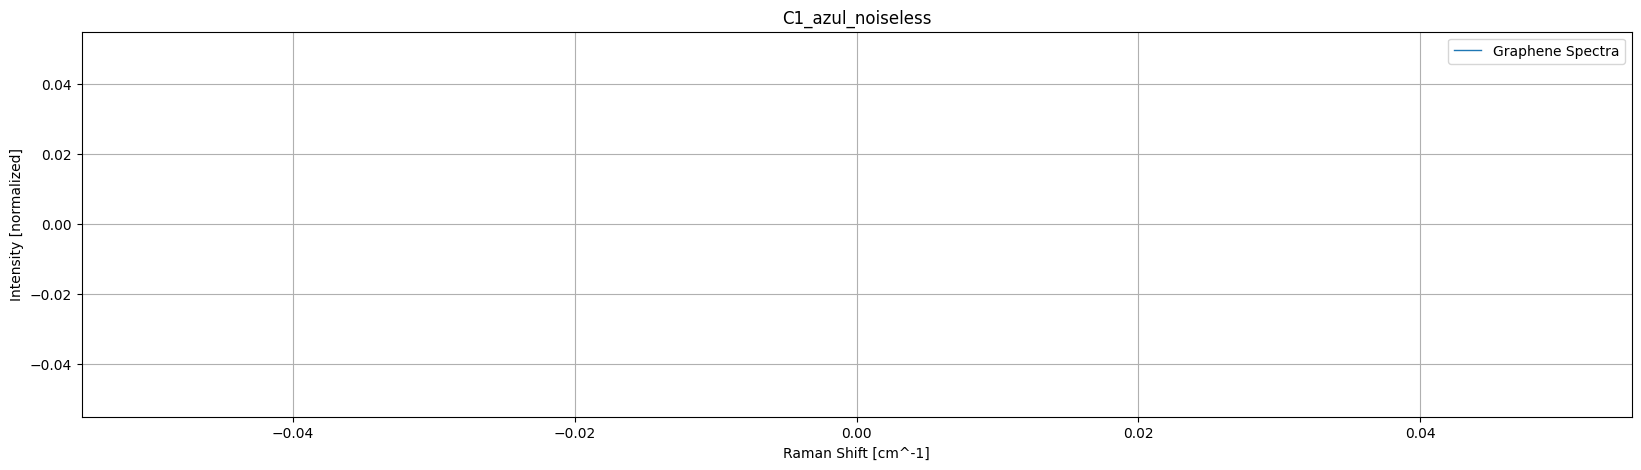

In [11]:
# Graphing
fig1 = plt.figure(figsize=(20,5))
ax = fig1.add_subplot(1,1,1)
ax.plot(df,linewidth=1,label='Graphene Spectra')
ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_noiseless')
ax.legend()
plt.show()

In [6]:
'''
PEAK FINDING.
'''
# Peak Finding
height = 0.025
prominence = 0.025
distance = None 
p, _ = fp(x=df.intensity,height = height, prominence = prominence, distance = distance)
peaks = df.iloc[p]
n = len(peaks) # total peaks found
print(peaks)

Empty DataFrame
Columns: [intensity]
Index: []


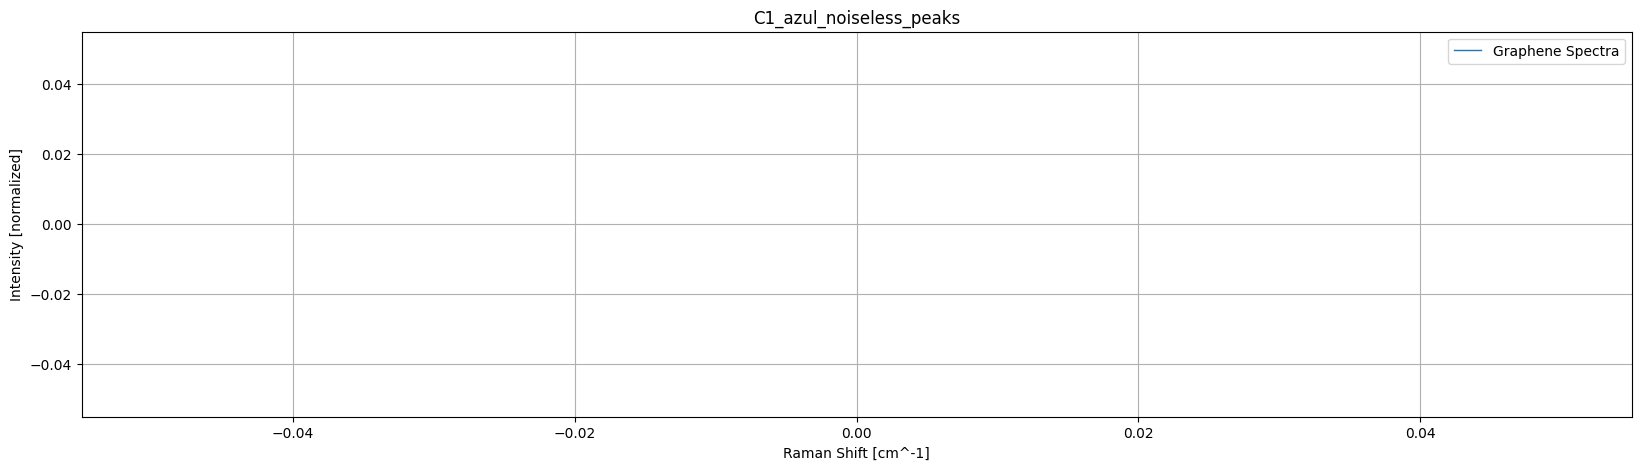

In [7]:
# Graphing
fig2 = plt.figure(figsize=(20,5))
ax = fig2.add_subplot(1,1,1)
ax.plot(df,linewidth=1,label='Graphene Spectra')
ax.scatter(peaks.index.values,peaks)
ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_noiseless_peaks')
ax.legend()
plt.show()

In [8]:
'''
LORENTZ FITTING.
'''
def add_peak(prefix, center, amplitude=0.05, sigma=0.5):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + 'center'].set(center)
    pars[prefix + 'amplitude'].set(amplitude)
    pars[prefix + 'sigma'].set(sigma, min=0)
    return peak, pars
    
xData, yData = np.loadtxt(filename + '_noiseless.txt', unpack= True)

model = LinearModel(prefix='bkg_')
params = model.make_params(a=0, b=0, c=0)

rough_peak_positions = peaks.index.values
for i, cen in enumerate(rough_peak_positions):
    peak, pars = add_peak('lz%d_' % (i+1), cen)
    model = model + peak
    params.update(pars)

init = model.eval(params, x=xData)
result = model.fit(yData, params, x=xData)
comps = result.eval_components()
report = result.fit_report(min_correl=0.5)

f = open(filename + '_fit_report.txt', 'w') #save report as txt
f.write(report)
f.close()

print(report)


ValueError: too many values to unpack (expected 2)

In [ ]:
# Graphing
fig3 = plt.figure(figsize=(20,18))
ax = fig3.add_subplot(3,1,3)
bx = fig3.add_subplot(3,1,2)
cx = fig3.add_subplot(3,1,1)

ax.plot(df,linewidth=1,label='Graphene Spectra') # experimental data
ax.scatter(peaks.index.values,peaks) # peaks fitting

bx.plot(df,linewidth=1,label='Graphene Spectra') # experimental data
bx.scatter(peaks.index.values,peaks) # peaks fitting

cx.plot(df,linewidth=1,label='Graphene Spectra') # experimental data
cx.scatter(peaks.index.values,peaks) # peaks fitting

# lorentz fitting
#x = np.arange(1000, 3000, 0.01)

for name, comp in comps.items():
    ax.plot(xData,comp, '--',linewidth=1,label=name,alpha = 1.0) 
    ax.fill_between(xData, comp, '--', alpha=.2, label=name + 'fill')
    
bx.plot(xData, result.best_fit, label='Lorentz fitting (best fit)', alpha=1.0)
bx.fill_between(xData, result.best_fit,label='Lorentz fitting fill', alpha=.2)

ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_lorentz_fitting_splitted')
ax.legend()


bx.grid()
bx.set_ylabel('Intensity [normalized]')
bx.set_xlabel('Raman Shift [cm^-1]')
bx.set_title(filename + '_lorentz_fitting')
bx.legend()

cx.grid()
cx.set_ylabel('Intensity [normalized]')
cx.set_xlabel('Raman Shift [cm^-1]')
cx.set_title(filename + '_noiseless_peaks')
cx.legend()

plt.savefig(filename + '_fit_graphs.png') #save graphs as png
plt.show()